In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandasql import sqldf
from sklearn.preprocessing import scale
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree

df = pd.read_csv('data.csv')
df.head()

/Users/Lorentz/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,customer_id,product,quantity_ordered,price_each,purchase_address,month,year,day,city,code,sales,order_date,hour,minute,count
0,295665,Macbook Pro Laptop,1,1700.00,"136 Church St, New York City, NY 10001",12,2019,30,New York City (NY),NY,1700.00,12/30/19 00:01,0,1,1
1,295666,LG Washing Machine,3,600.00,"562 2nd St, New York City, NY 10001",12,2019,29,New York City (NY),NY,600.00,12/29/19 07:03,7,3,1
2,295667,USB-C Charging Cable,3,11.95,"277 Main St, New York City, NY 10001",12,2019,12,New York City (NY),NY,11.95,12/12/19 18:21,18,21,1
3,295668,27in FHD Monitor,2,149.99,"410 6th St, San Francisco, CA 94016",12,2019,22,San Francisco (CA),CA,149.99,12/22/19 15:13,15,13,1
4,295669,USB-C Charging Cable,1,11.95,"43 Hill St, Atlanta, GA 30301",12,2019,18,Atlanta (GA),GA,11.95,12/18/19 12:38,12,38,1


In [2]:
type(df["order_date"])

pandas.core.series.Series

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185950 entries, 0 to 185949
Data columns (total 15 columns):
customer_id         185950 non-null int64
product             185950 non-null object
quantity_ordered    185950 non-null object
price_each          185950 non-null float64
purchase_address    185950 non-null object
month               185950 non-null int64
year                185950 non-null int64
day                 185950 non-null int64
city                185950 non-null object
code                185950 non-null object
sales               185950 non-null float64
order_date          185950 non-null object
hour                185950 non-null int64
minute              185950 non-null int64
count               185950 non-null int64
dtypes: float64(2), int64(7), object(6)
memory usage: 21.3+ MB


In [4]:
df["order_date"] = df["order_date"].astype('datetime64[ns]')

In [5]:
print(df["order_date"].max(),"\n",df["order_date"].min())

2020-01-01 05:13:00 
 2019-01-01 03:07:00


In [6]:
df['days_since'] = (pd.Timestamp('2020-01-01') - df['order_date']).dt.days

In [7]:
# Display the data after transformation
df.head()

,customer_id,product,quantity_ordered,price_each,purchase_address,month,year,day,city,code,sales,order_date,hour,minute,count,days_since
0,295665,Macbook Pro Laptop,1,1700.00,"136 Church St, New York City, NY 10001",12,2019,30,New York City (NY),NY,1700.00,2019-12-30 00:01:00,0,1,1,1
1,295666,LG Washing Machine,3,600.00,"562 2nd St, New York City, NY 10001",12,2019,29,New York City (NY),NY,600.00,2019-12-29 07:03:00,7,3,1,2
2,295667,USB-C Charging Cable,3,11.95,"277 Main St, New York City, NY 10001",12,2019,12,New York City (NY),NY,11.95,2019-12-12 18:21:00,18,21,1,19
3,295668,27in FHD Monitor,2,149.99,"410 6th St, San Francisco, CA 94016",12,2019,22,San Francisco (CA),CA,149.99,2019-12-22 15:13:00,15,13,1,9
4,295669,USB-C Charging Cable,1,11.95,"43 Hill St, Atlanta, GA 30301",12,2019,18,Atlanta (GA),GA,11.95,2019-12-18 12:38:00,12,38,1,13


In [24]:
# Compute recency, frequency, and average purchase amount
rfm = sqldf("SELECT customer_id, MIN(days_since) AS 'recency', COUNT(*) AS 'frequency', AVG(sales) AS 'amount' FROM df GROUP BY 1")

In [25]:
rfm.describe()

,customer_id,recency,frequency,amount
count,178437.000000,178437.000000,178437.000000,178437.000000
mean,230452.000000,165.637956,1.042104,182.687511
std,51510.469329,107.145857,0.211617,328.497937
min,141234.000000,-1.000000,1.000000,2.990000
25%,185843.000000,66.000000,1.000000,11.950000
50%,230452.000000,166.000000,1.000000,14.950000
75%,275061.000000,259.000000,1.000000,150.000000
max,319670.000000,364.000000,5.000000,3400.000000


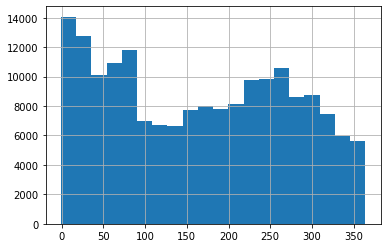

In [26]:
rfm.recency.hist(bins=20)


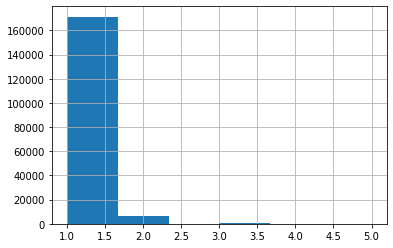

In [27]:
rfm.frequency.hist(bins=6)


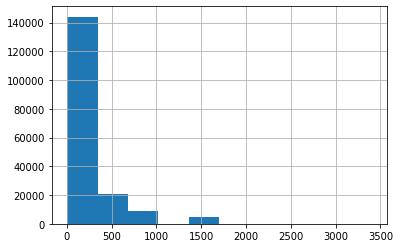

In [28]:
rfm.amount.hist()


In [29]:
# Copy customer data into new data frame
new_data = rfm

In [30]:
new_data.head()
new_data = new_data.set_index(new_data.customer_id).iloc[:,1:4]
new_data.head()

,recency,frequency,amount
customer_id,,,
141234,343,1,700.00
141235,337,1,14.95
141236,348,1,23.98
141237,360,1,149.99
141238,340,1,11.99


In [15]:
# Take the log-transform of the amount, and plot
new_data.amount = np.log(new_data.amount)

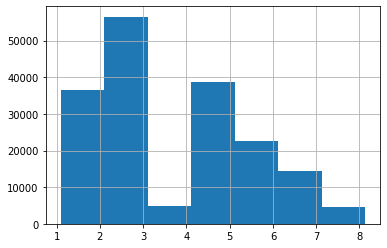

In [16]:
new_data.amount.hist(bins=7)

In [17]:
# Standardize variables
new_data = pd.DataFrame(scale(new_data), index=new_data.index, columns=new_data.columns)
new_data.head()

,recency,frequency,amount
customer_id,,,
141234,1.655337,-0.198966,1.528147
141235,1.599339,-0.198966,-0.536610
141236,1.702003,-0.198966,-0.282964
141237,1.814000,-0.198966,0.701190
141238,1.627338,-0.198966,-0.655050


In [18]:
# HIERARCHICAL SEGMENTATION
# Take a 10% sample
customers_sample = rfm.iloc[::10, :]
new_data_sample  = new_data.iloc[::10, :]



In [19]:
# Perform hierarchical clustering on distance metrics
c = linkage(new_data_sample, method='ward')

In [20]:
# Set to 3 segments
members = pd.DataFrame(cut_tree(c, n_clusters = 3), index=new_data_sample.index, columns=['ClusterNumber'])

In [21]:
members.ClusterNumber.value_counts(sort=False)

0    7544
1    9568
2     732
Name: ClusterNumber, dtype: int64

In [22]:
# Show 10 first customers, frequency table
members.iloc[0:10]

,ClusterNumber
customer_id,
141234,0
141244,0
141254,1
141264,0
141274,1
141284,1
141294,0
141304,1
141314,0


In [23]:
customers_sample_new = customers_sample.set_index(customers_sample.customer_id).iloc[:,1:4]


customers_sample_new.groupby(members.ClusterNumber).mean()


,recency,frequency,amount
ClusterNumber,,,
0,164.952015,1.000000,403.484805
1,165.956940,1.000000,10.294980
2,167.763661,2.045082,258.850364
